# Observables from twopoppy

You need to **clone** (not download) the `twopoppy code`:

    git clone https://github.com/birnstiel/two-pop-py
    
Then go in the repository and install it e.g. with

    pip install -e .

All the imports and setup stuff:

In [1]:
from planck_B_nu import planck_B_nu
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u
from scipy.integrate import cumtrapz
import os, pandas as pd


#import twopoppy
#from twopoppy.wrapper import model_wrapper
#from twopoppy.args import args
from twopoppy import model

c_light = c.c.cgs.value
au = u.au.to('cm')
pc = u.pc.to('cm')
K =  u.Kelvin
M_sun = c.M_sun.cgs.value
year = u.year.to('s')
arcsec_sq = (u.arcsec**2).to(u.sr)  # arcsec**2 in steradian
R_sun        = 69550800000.0
%matplotlib inline
plt.style.use({'figure.dpi': 200})

In [128]:
from importlib import reload
reload(model)

<module 'twopoppy.model' from '/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/model.py'>

Get some data

In [2]:
n_r       = 200
n_t       = 100
r_in      = 5*au
r_out     = 300*au
r         = np.logspace(np.log10(r_in),np.log10(r_out),n_r)
tstar     = 4010
rstar     = 1.806*R_sun
TT = ((0.05**0.25 * tstar * (r / rstar)**-0.5)**4 + (7.)**4)**0.25

In [107]:
print(TT)

[ 77.70630411  76.9110671   76.12397067  75.34493155  74.57386733
  73.81069644  73.05533816  72.30771259  71.56774064  70.83534406
  70.11044537  69.3929679   68.68283578  67.97997388  67.28430789
  66.59576422  65.91427007  65.23975336  64.57214276  63.91136769
  63.25735827  62.61004534  61.96936047  61.33523592  60.70760464
  60.08640029  59.47155718  58.86301033  58.26069542  57.66454877
  57.07450737  56.49050887  55.91249155  55.34039432  54.77415673
  54.21371895  53.65902176  53.11000657  52.56661537  52.02879076
  51.49647594  50.96961468  50.44815134  49.93203085  49.42119873
  48.91560103  48.41518438  47.91989595  47.42968348  46.94449522
  46.46427998  45.9889871   45.51856642  45.05296833  44.59214372
  44.136044    43.68462108  43.23782737  42.79561577  42.35793969
  41.924753    41.49601007  41.07166575  40.65167535  40.23599464
  39.82457988  39.41738777  39.01437546  38.61550056  38.22072114
  37.82999568  37.44328311  37.06054282  36.68173458  36.30681863
  35.93575

## Calculate optical depth and emission profiles

Define the function that reconstructs the size distribution

Now we call the function, passing our selected simulation, the time at which we want the results, and size/wavelength/opacity grids

In [4]:
for ALPHA in [0.01, 0.005]:
    for MD in [0.1, 0.05]:
        for rc in [20, 80]:
            for v_frag in [1000, 3000]:             
                
                r_c    = rc*au        # disk characteristic radius [cm]
                rho_s  = 1.2          # material density of in Drazkowska
                M_star = M_sun        # stellar mass [g]
                M_disk = MD*M_star  # gas disk mass [g]
                d2g    = 0.01         # dust-to-gas ratio [-]
                a_0    = 1e-5         # initial particle size [cm]
# snapshot time [s]

                time  = np.logspace(2,6,n_t)*year

# initial conditions: gas and dust surface densities [g cm^-2]

                sig_g = (r/r_c)**-1*np.exp(-(r/r_c))
                sig_g = sig_g/np.trapz(2*np.pi*r*sig_g,x=r)*M_disk
                sig_d = d2g*sig_g

# power-law temperature [K]

                Temp     = 200.*(r/au)**-0.5

# alpha profile: a dip at 30*au - no scientific reason
                #alpha = ALPHA*np.ones_like(r)
                alpha = ALPHA*np.ones_like(r)-9e-3*np.exp(-(r-(2*r_c/3)*au)**2/(2*(5*au)**2))

# v_gas is only for non-evolving gas disks, where you still
# want the dust to feel a gas velocity (e.g. a steady-state disk)
                v_gas = np.zeros_like(r)

                estick = 1.0
                opacity = np.load('opacity.npz') # load an npz file (array)
                k_a = opacity['k_a'] #len(k_a) = 1500
                k_s = opacity['k_s'] #len(k_s) = 1500
                lam = opacity['lam']  #all the three are contained in opacity.npz
                a_opac = opacity['a'] #len(a_opac) = 1500
                n_lam = len(lam)
                
                res = model.run(r, a_0, time, sig_g, sig_d, v_gas, Temp, alpha, M_star, v_frag, rho_s, 1)

                t     = res[0]
                sig_d = res[1]
                sig_g = res[2]
                v_bar = res[3]
                v_gas = res[4]
                v_0   = res[5]
                v_1   = res[6]
                a_dr  = res[7]
                a_fr  = res[8]
                a_df  = res[9]
                a_t   = res[10]
                
                a = np.logspace(np.log10(a_0), np.log10(5 * a_t.max()), 150) 
                from twopoppy.distribution_reconstruction import reconstruct_size_distribution as rsd
                def get_distri( it, r, a, time, sig_g, sig_d, alpha, rho_s, Temp, M_star, v_frag, a0=a_0):
    
                    if Temp.ndim == 1:
                        T = Temp
                    else:
                        T = Temp[it]
    
                    distri = rsd(
                        r, 
                        a, 
                        time[it],
                        sig_g[it],
                        sig_d[it], 
                        alpha, 
                        rho_s, 
                        T, 
                        M_star, 
                        v_frag,
                        a_0 = 1e-5) 
                    return distri[:2]

        
                def get_results(r, t, a, Temp, sample_time, it, lam, a_opac, k_a, distance=140 * pc, flux_fraction=0.68):
    

    # interpolate opacity on the same particle size grid as the size distribution
   
                    kappa = np.array([10.**np.interp(np.log10(a), np.log10(a_opac), np.log10(k)) for k in k_a.T]).T  #interpolates the opacity
    
                    it = np.abs(t - sample_time).argmin()
    
                    if Temp.ndim == 1:
                        T = Temp
                    else:
                        T = Temp[it]
        
    # reconstruct the size distribution
        
                    sig_da, a_max = get_distri(2, r, a, time, sig_g, sig_d, alpha, rho_s, T, M_star, v_frag,a_0)
    
    # calculate planck function at every wavelength and radius

                    Bnu = planck_B_nu(c_light / (np.array(lam, ndmin=2).T), np.array(T, ndmin=2))  # shape = (n_lam, n_r)

    # calculate optical depth

                    tau = (kappa.T[:, :, np.newaxis] * sig_da[np.newaxis, :, :])  # shape = (n_l, n_a, n_r)
                    tau = tau.sum(1)  # shape = (n_l, n_r)

    # calculate intensity at every wavelength and radius for this snapshot
    # here the intensity is still in plain CGS units (per sterad)

                    intens = Bnu * (1 - np.exp(-tau))

    # calculate the fluxes
    
                    flux = distance**-2 * cumtrapz(2 * np.pi * r * intens, x=r, axis=1, initial=0)
    
                    flux_t = flux[:, -1] / 1e-23  # store the integrated flux density in Jy (sanity check: TW Hya @ 870 micron and 54 parsec is about 1.5 Jy)

    # converted intensity to Jy/arcsec**2

                    Inu = intens * arcsec_sq / 1e-23
    
#   interpolate radius whithin which >=68% of the dust mass is  # Effective radius (see Tripani)
    
                    rf = np.array([np.interp(flux_fraction, _f / _f[-1], r) for _f in flux])
    
                    path = '/home/apo/Codes/two-pop-py/results_gap.csv'
    
                    import pandas as pd
        
                    data_dict = {'mdisk': [M_disk/M_sun], 'alpha' : [alpha[0]], 'r_c [AU]' : [r_c/au], 'v_frag' : [v_frag], 'reff [AU]' : [rf[2]/au], 'fluxmm' : [flux_t[2]]}
                    df = pd.DataFrame(data=data_dict)
                    column_order = [ 'mdisk', 'alpha', 'r_c [AU]', 'v_frag', 'reff [AU]', 'fluxmm']
                    df = df[column_order]

    #df = df.append(data_dict, ignore_index=True)
                    with open('/home/apo/Codes/two-pop-py/results_gap.csv', 'a') as f:
                        df.to_csv(f, header=False)
     
                    return rf[2], flux_t[2], tau, Inu, sig_da, a_max
        

                
                sample_time = t.searchsorted(1e6 * year)  #check searchsorted
                IT  = [-1]
                rf, flux_t, tau, Inu, sig_da, a_max = get_results(r, t, a, Temp, sample_time, IT, lam, a_opac, k_a)
                

toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


toy model running ... Done!


/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


Plot the reconstructed size distribution

In [9]:
df = pd.read_csv('/home/apo/Codes/two-pop-py/results_gap.csv')
df

,Unnamed: 0,Mdisk,alpha,rc,vfrag,Reff,Fmm
0,0,0.10,0.010,20,1000,39.684777,0.896838
1,0,0.10,0.010,20,3000,39.869248,0.900399
2,0,0.10,0.010,80,1000,72.714203,1.311603
3,0,0.10,0.010,80,3000,73.103684,1.322964
4,0,0.05,0.010,20,1000,33.851584,0.666498
5,0,0.05,0.010,20,3000,34.041388,0.668421
6,0,0.05,0.010,80,1000,62.226403,0.817415
7,0,0.05,0.010,80,3000,62.613338,0.824737
8,0,0.10,0.005,20,1000,39.590547,0.893488
9,0,0.10,0.005,20,3000,39.756029,0.897591


In [16]:
df_01M  =  df.loc[df['Mdisk'] == 0.1]
df_005M  =  df.loc[df['Mdisk'] == 0.05]
#df_rf   =  df.loc[:,'Reff']
#df_Fmm  =  df["Fmm"].values

In [50]:
Fmmall  = df['Fmm'].values
Reffall = df['Reff'].values
Reff01  = df_01M['Reff'].values
Reff005 = df_005M['Reff'].values
Fmm01   = df_01M['Fmm'].values
Fmm005  = df_005M['Fmm'].values

In [34]:
Reff01.shape

(8,)

## Plot the opacity

In [17]:
opacity = np.load('opacity.npz') # load an npz file (array)
k_a = opacity['k_a'] #len(k_a) = 1500
k_s = opacity['k_s'] #len(k_s) = 1500
lam = opacity['lam']  #all the three are contained in opacity.npz
a_opac = opacity['a'] #len(a_opac) = 1500
n_lam = len(lam)

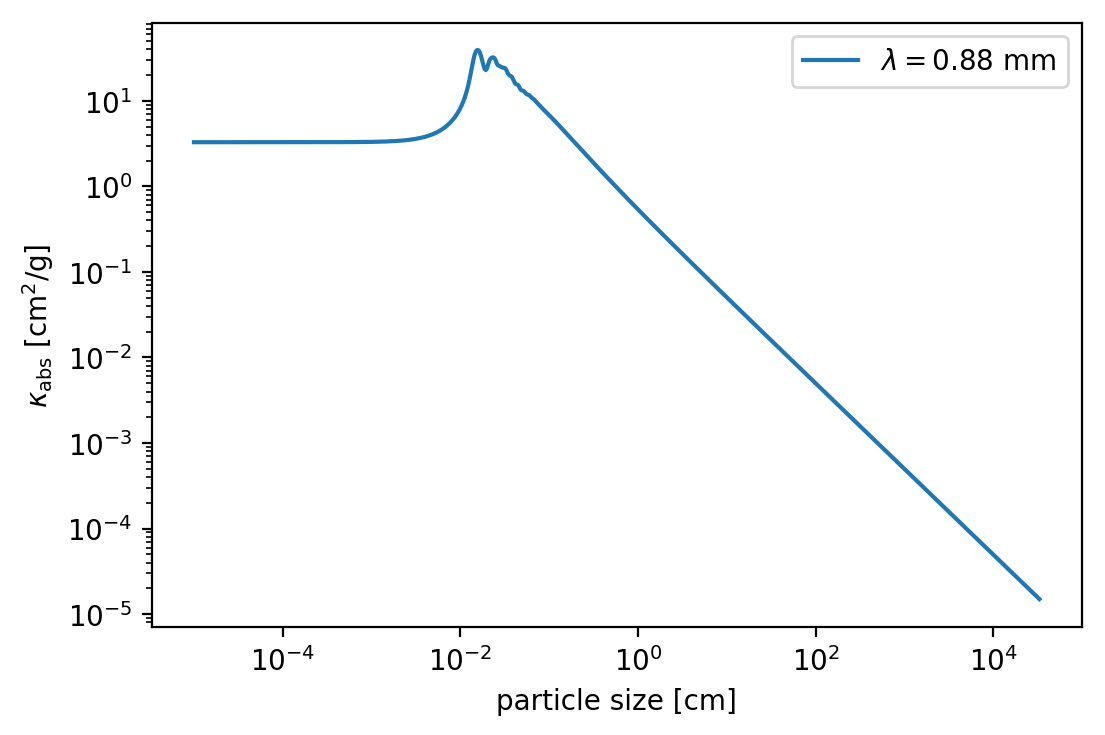

In [24]:
f, ax = plt.subplots()
#for ilam in range(n_lam):
ax.loglog(a_opac, k_a[:, 2], label='$\lambda = {:.3g}$ mm'.format(10 * lam[2]))
ax.legend()
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\kappa_\mathrm{abs}$ [cm$^2$/g]');

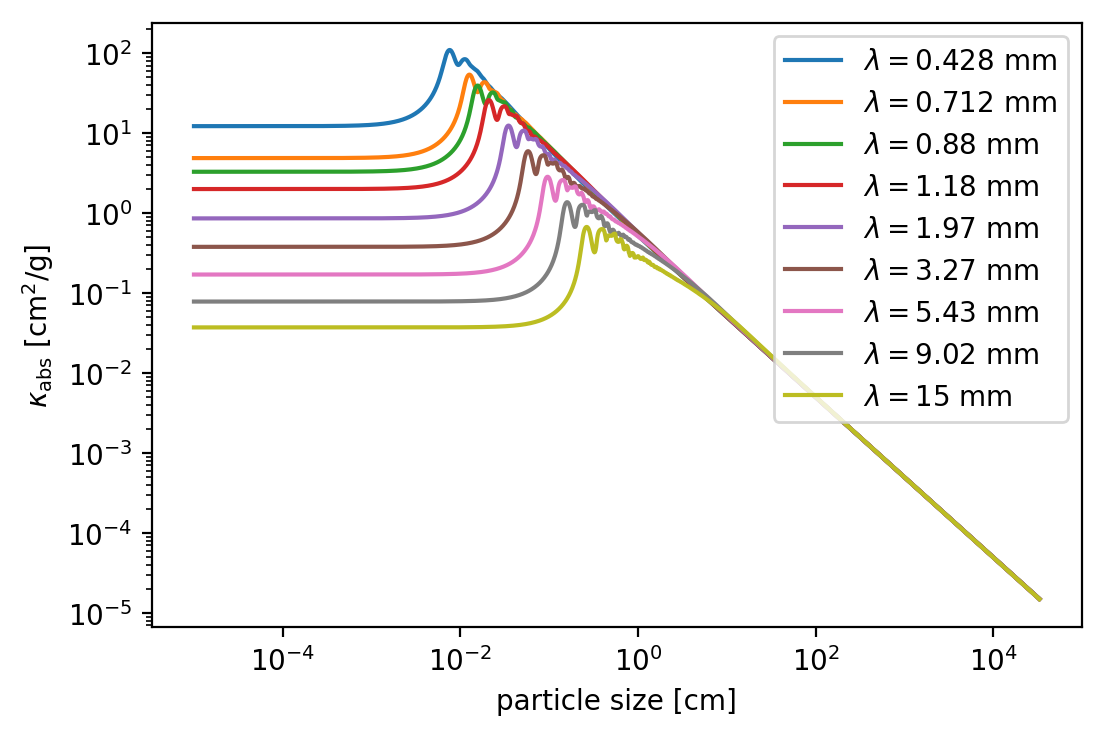

In [6]:
f, ax = plt.subplots()
for ilam in range(n_lam):
    ax.loglog(a_opac, k_a[:, ilam], label='$\lambda = {:.3g}$ mm'.format(10 * lam[ilam]))
ax.legend()
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\kappa_\mathrm{abs}$ [cm$^2$/g]');

## Plot the emission profiles

## Plot the spectral dependence of $r_\mathrm{eff}$ and the flux

In [26]:
lam[2]

0.087999999999999995

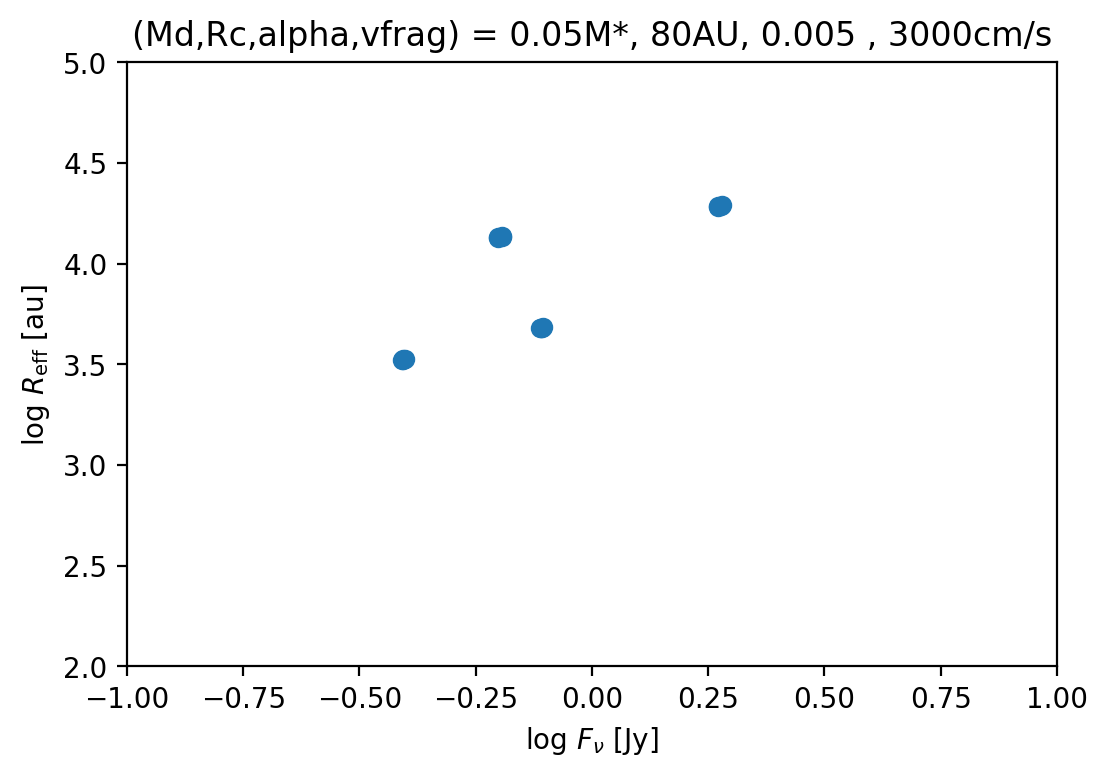

In [71]:
#f, ax = plt.subplots(1, 1, figsize=(6, 10))
    
plt.scatter(np.log(Fmmall),np.log(Reffall))

plt.ylim(2, 5)
plt.xlim(-1, 1)
plt.ylabel(r'log $R_\mathrm{eff}$ [au]')
plt.xlabel(r'log $F_\nu$ [Jy]')
plt.title('(Md,Rc,alpha,vfrag) = {:.4g}M*, {:.4g}AU, {:.4g} , {:.4g}cm/s'.format(M_disk / M_star, r_c / au, alpha[0], v_frag ))
f.savefig('fig1.pdf')

Text(0.5,0,'log $F_\\nu$ [mJy]')

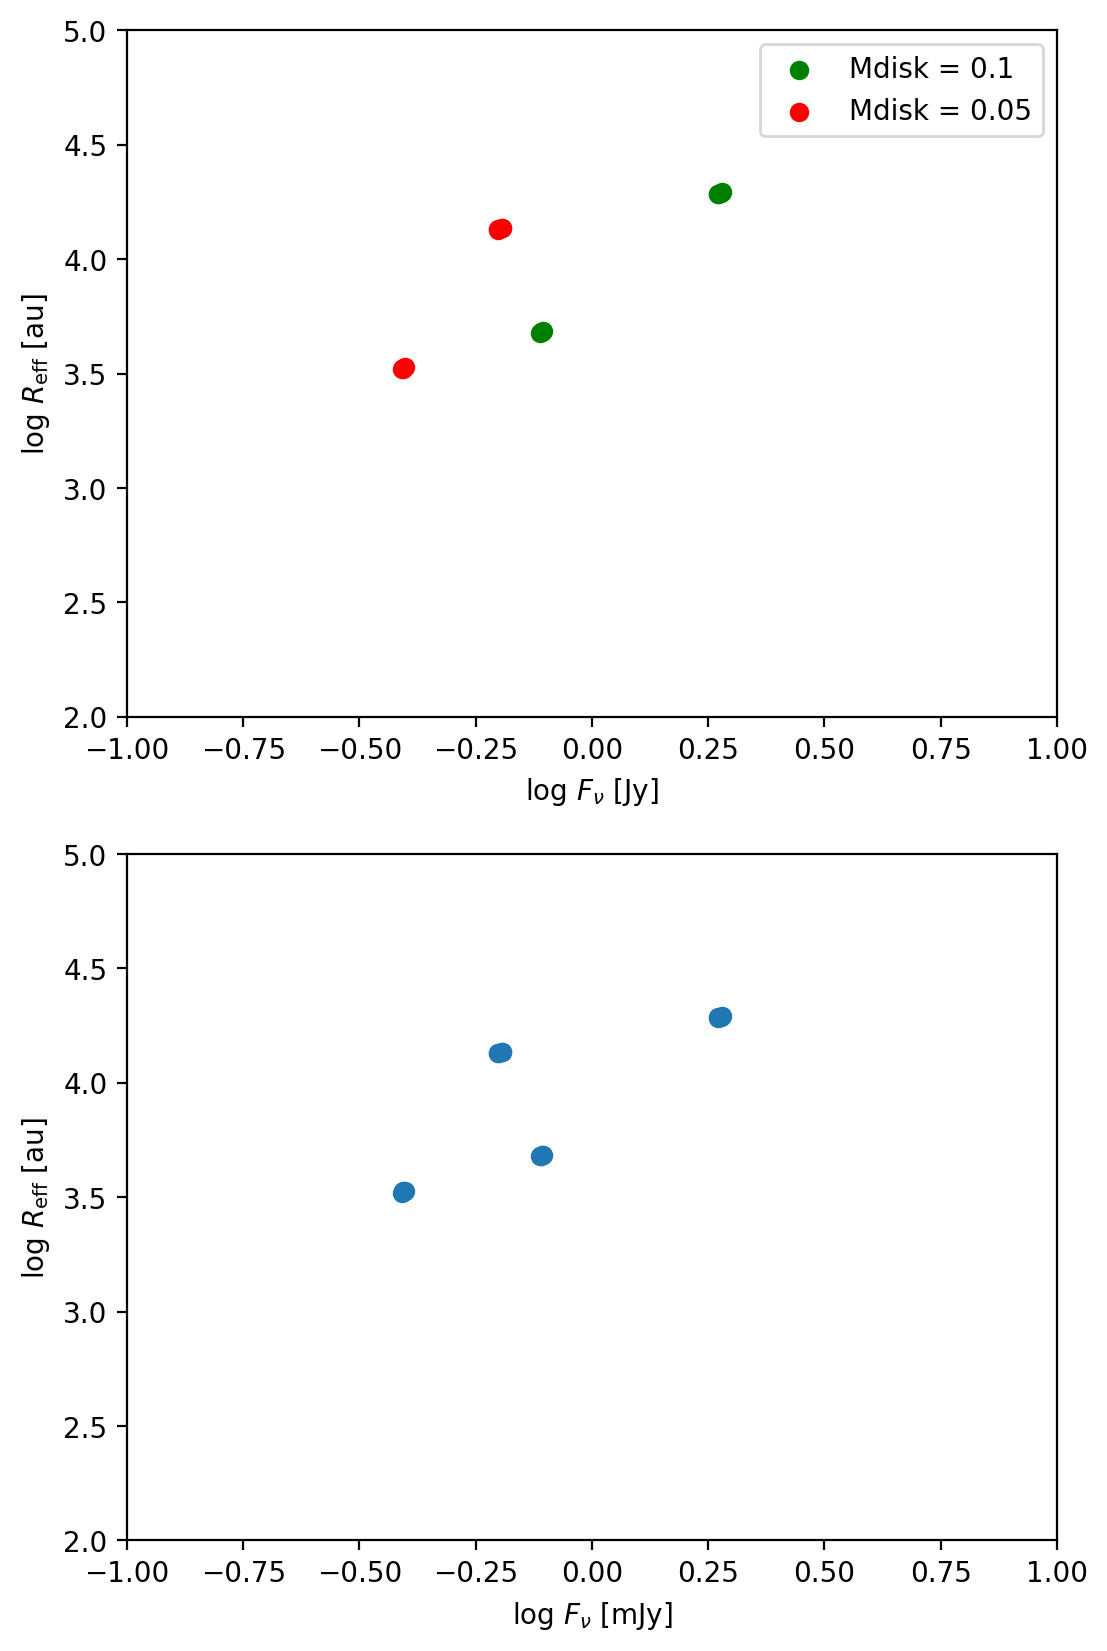

In [99]:
f, ax = plt.subplots(2, 1, figsize=(6, 10))
ax[0].scatter(np.log(Fmm01),np.log(Reff01), c = 'g', label='Mdisk = 0.1')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(2, 5)
ax[0].set_xlabel(r'log $F_\nu$ [Jy]')
ax[0].set_ylabel(r'log $R_\mathrm{eff}$ [au]')


ax[0].scatter(np.log(Fmm005),np.log(Reff005), c = 'r',label='Mdisk = 0.05')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(2, 5)
ax[0].set_xlabel(r'log $F_\nu$ [Jy]')
ax[0].set_ylabel(r'log $R_\mathrm{eff}$ [au]')
ax[0].legend();
ax[1].scatter(np.log(Fmmall),np.log(Reffall), )
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(2, 5)
ax[1].set_ylabel(r'log $R_\mathrm{eff}$ [au]')
ax[1].set_xlabel(r'log $F_\nu$ [mJy]')
#ax[0].set_title('(Md,Rc,alpha,vfrag) = {:.4g}M*, {:.4g}AU, {:.4g} , {:.4g}cm/s'.format(M_disk / M_star, r_c / au, alpha[0], v_frag ))
#f.savefig('fig1.pdf')